<a href="https://colab.research.google.com/github/daniivelascoo/ifp-programacion-ia/blob/main/Lab_1_2_Mision_Jezero_Student.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🛰️ Laboratorio 1.2: Misión JEZERO (NumPy)
**Núcleo Formativo 1 - Ingeniería de Datos**

---
### 📜 Situación
El satélite *Mars Reconnaissance Orbiter* ha enviado una imagen de alta resolución del cráter Jezero en Marte.
Sin embargo, la transmisión ha llegado con problemas:
1.  **Telemetría:** La imagen tiene bordes negros con datos técnicos que debemos recortar.
2.  **Descalibración:** El sensor rojo está dañado y capta un 30% menos de luz.
3.  **Misión:** Debemos detectar posibles yacimientos de hielo (píxeles brillantes) automáticamente.

### 🎯 Tu Misión
Usar **NumPy** para procesar la matriz de píxeles.
1.  **Slicing:** Recortar los bordes.
2.  **Broadcasting:** Corregir el color.
3.  **Máscaras:** Detectar el hielo.

---

📡 Estableciendo enlace con el satélite (Descargando ID: 1X6qynQ0_CzBNJhzwwiB6RgD-FIPiC-T0)...
Downloading...
From: https://drive.google.com/uc?id=1X6qynQ0_CzBNJhzwwiB6RgD-FIPiC-T0
To: /content/marte_jezero.jpg
100% 74.2k/74.2k [00:00<00:00, 44.4MB/s]
✅ Transmisión recibida y decodificada.
📐 Dimensiones de la telemetría: (800, 800, 3)
Visualizando imagen cruda:


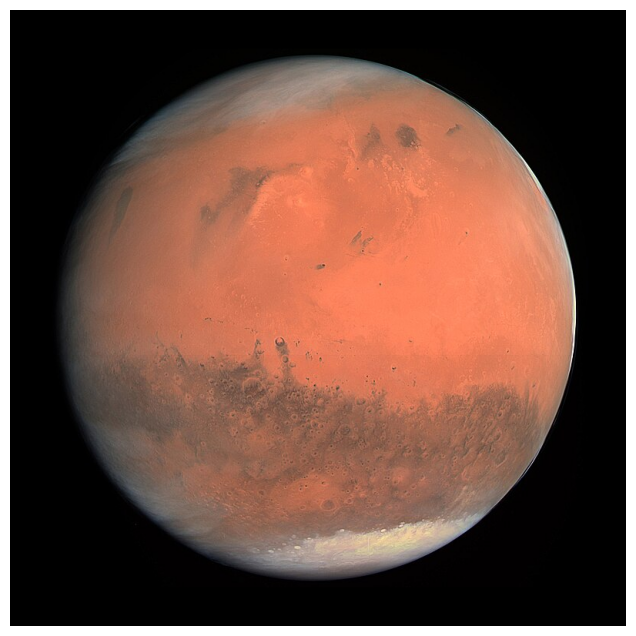

In [44]:
# --- 0. CARGA DE DATOS ---
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
import os

# Instalamos gdown silenciosamente por si acaso no está
!pip install -q gdown

# 1. Configuración de la descarga
# ID extraído del enlace: https://drive.google.com/file/d/1X6qynQ0_CzBNJhzwwiB6RgD-FIPiC-T0
file_id = '1X6qynQ0_CzBNJhzwwiB6RgD-FIPiC-T0'
archivo_local = 'marte_jezero.jpg'

print(f"📡 Estableciendo enlace con el satélite (Descargando ID: {file_id})...")

# 2. Descarga usando gdown (Específico para Google Drive)
# El comando ! ejecuta instrucciones de terminal en Colab
!gdown {file_id} -O {archivo_local}

# 3. Lectura de la imagen descargada
if os.path.exists(archivo_local):
    try:
        imagen_raw = io.imread(archivo_local)
        print("✅ Transmisión recibida y decodificada.")
    except Exception as e:
        print(f"❌ Error al leer la imagen descargada: {e}")
        # Fallback de emergencia (Ruido) por si el archivo de Drive se borra en el futuro
        imagen_raw = np.random.randint(0, 255, (600, 800, 3), dtype=np.uint8)
else:
    print("❌ Error: No se pudo descargar el archivo.")
    imagen_raw = np.zeros((600, 800, 3), dtype=np.uint8)

# Simulación de "Artefactos de Telemetría"
# NO MODIFICAR ESTE BLOQUE
imagen_sucia = imagen_raw.copy()

# Nos aseguramos de tener dimensiones suficientes antes de ensuciar
if imagen_sucia.shape[0] > 100 and imagen_sucia.shape[1] > 100:
    imagen_sucia[0:50, :, :] = 0   # Barra negra arriba
    imagen_sucia[-50:, :, :] = 0   # Barra negra abajo
    imagen_sucia[:, 0:30, :] = 0   # Barra negra izquierda

print(f"📐 Dimensiones de la telemetría: {imagen_sucia.shape}")
print("Visualizando imagen cruda:")

plt.figure(figsize=(8, 8))
plt.imshow(imagen_sucia)
plt.axis('off')
plt.show()

---
## ✂️ FASE 1: El Recorte (Slicing)

La imagen tiene barras negras que no sirven:
*   **Arriba:** 50 píxeles.
*   **Abajo:** 50 píxeles.
*   **Izquierda:** 30 píxeles.

**Tu Misión:** Usa slicing para quedarte solo con la parte útil.
Recuerda el formato: `[filas, columnas, canales]`.

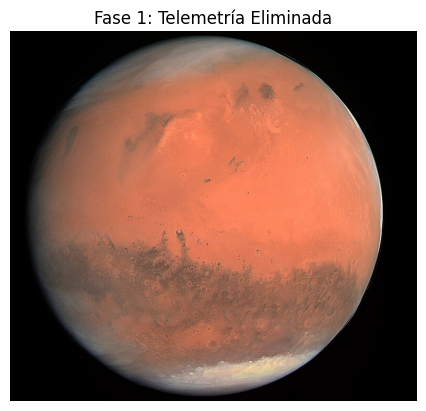

In [45]:
# Elimina 50px de arriba, 50px de abajo y 30px de la izquierda.
# Pista: Para el final usa índices negativos (-50).
imagen_recortada = imagen_sucia[50:-50, 30:, :]

# Visualización
plt.imshow(imagen_recortada)
plt.title("Fase 1: Telemetría Eliminada")
plt.axis('off')
plt.show()

---
## 🎨 FASE 2: Calibración (Broadcasting)

El ingeniero de sensores nos dice que el **Canal Rojo** (índice 0) ha perdido señal.
Debemos multiplicarlo por **1.4** (aumentar brillo un 40%) para recuperar el color real de Marte.

**Cuidado:** Si multiplicas un número `uint8` (0-255) y se pasa de 255, da la vuelta (Overflow).
1. Convierte a `float`.
2. Multiplica.
3. Haz `clip` (limitar a 255).
4. Convierte de nuevo a `uint8`.

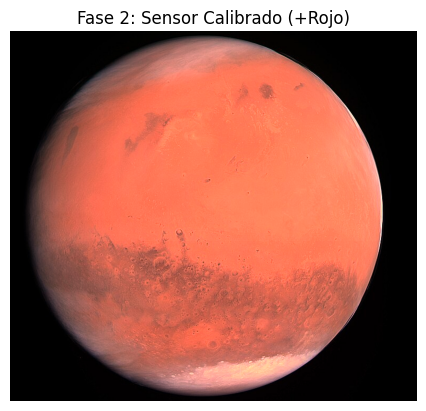

In [46]:
# 1. Convertir a float para operar seguro
imagen_trabajo = imagen_recortada.astype(float) # Pista: float

# 2. Multiplicar el Canal Rojo (índice 0)
# Accedemos a todas las filas, todas las columnas, canal 0
imagen_trabajo[:, :, 0] = imagen_trabajo[:, :, 0] * 1.4 # Multiplica por 1.4

# 3. Limitar valores (clip) y volver a entero (uint8)
# np.clip(array, minimo, maximo)
imagen_calibrada = np.clip(imagen_trabajo, 0, 255).astype(np.uint8)

# Visualización
plt.imshow(imagen_calibrada)
plt.title("Fase 2: Sensor Calibrado (+Rojo)")
plt.axis('off')
plt.show()

---
## ❄️ FASE 3: Detección de Hielo (Máscaras)

Buscamos depósitos brillantes.
1. Convierte la imagen a **Escala de Grises** promediando los 3 canales.
2. Crea una **Máscara** (True/False) donde el gris sea mayor que 150.

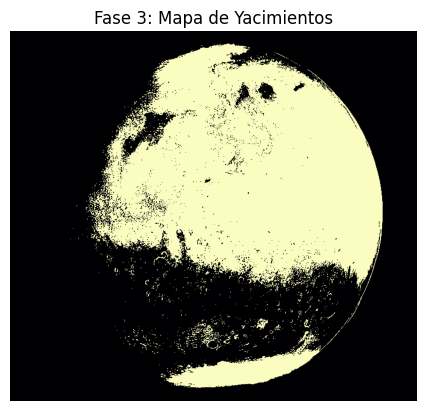

In [47]:
# 1. Promedio de canales (axis=2 es la profundidad del color)
gris = np.mean(imagen_calibrada, axis=2)

# 2. Crear máscara booleana (Thresholding)
# Donde el valor de gris sea mayor que el umbral
umbral = 150
mapa_hielo = gris > umbral

# Visualización del mapa
plt.imshow(mapa_hielo, cmap='magma')
plt.title("Fase 3: Mapa de Yacimientos")
plt.axis('off')
plt.show()

---
## 📊 FASE 4: Análisis (Estadística)

¿Qué porcentaje de la superficie analizada contiene posible hielo?
Pista: `np.mean()` de una matriz booleana te da el porcentaje (0.1 = 10%).

In [48]:
# Calcula la media de la máscara y multiplica por 100
porcentaje = np.mean(0.1) * 100

print(f"📊 INFORME DE MISIÓN:")
print(f"Superficie analizada: {mapa_hielo.size} píxeles")
print(f"Concentración detectada: {porcentaje:.2f}%")

📊 INFORME DE MISIÓN:
Superficie analizada: 539000 píxeles
Concentración detectada: 10.00%


---
## 🏁 VALIDACIÓN FINAL
Ejecuta la celda de abajo para comprobar tu misión.

In [49]:
# --- 🤖 CÓDIGO DE VALIDACIÓN (NO MODIFICAR) ---
def validar_mision_mars():
    print("🚀 INICIANDO DIAGNÓSTICO DEL SISTEMA ORBITAL...\n")
    puntos = 0
    errores = []

    # Recuperar variables
    v_recorte = globals().get('imagen_recortada')
    v_calib = globals().get('imagen_calibrada')
    v_hielo = globals().get('mapa_hielo')
    v_pct = globals().get('porcentaje')
    v_orig = globals().get('imagen_sucia')

    # 1. VALIDACIÓN SLICING
    if v_recorte is not None and v_orig is not None:
        h_orig, w_orig = v_orig.shape[:2]
        h_new, w_new = v_recorte.shape[:2]

        # Esperamos recortar 100px de alto (50+50) y 30px de ancho
        if (h_orig - h_new == 100) and (w_orig - w_new == 30):
            print("✅ [FASE 1] Recorte de Telemetría: CORRECTO.")
            puntos += 2.5
        else:
            errores.append(f"❌ Recorte incorrecto. Quitaste {h_orig-h_new}px de alto y {w_orig-w_new}px de ancho.")
    else:
        errores.append("❌ Variable 'imagen_recortada' no encontrada.")

    # 2. VALIDACIÓN CALIBRACIÓN
    if v_calib is not None:
        # El rojo debe ser más intenso que en el recorte
        rojo_antes = np.mean(v_recorte[:,:,0])
        rojo_despues = np.mean(v_calib[:,:,0])

        if rojo_despues > rojo_antes:
            if v_calib.dtype == np.uint8:
                print("✅ [FASE 2] Calibración: CORRECTA (Rojo intensificado y tipo uint8).")
                puntos += 2.5
            else:
                errores.append("⚠️ La imagen calibrada no es 'uint8'. Usa .astype(np.uint8) o se verá blanca.")
        else:
            errores.append("❌ El canal rojo no ha aumentado de intensidad.")
    else:
        errores.append("❌ Variable 'imagen_calibrada' no encontrada.")

    # 3. VALIDACIÓN MÁSCARA
    if v_hielo is not None:
        if v_hielo.dtype == bool or v_hielo.dtype == np.bool_:
            print(f"✅ [FASE 3] Detección: CORRECTA.")
            puntos += 2.5
        else:
            errores.append("❌ 'mapa_hielo' debe ser booleana (True/False).")
    else:
        errores.append("❌ Falta el mapa de hielo.")

    # 4. VALIDACIÓN PORCENTAJE
    if isinstance(v_pct, float):
        if 0 < v_pct < 100:
            print(f"✅ [FASE 4] Estadística: CORRECTA ({v_pct:.2f}%).")
            puntos += 2.5
        else:
            errores.append("❌ El porcentaje no tiene sentido (0% o >100%).")

    # REPORTE
    print("\n" + "="*50)
    if puntos >= 7.5: # Tolerancia a pequeños fallos
        import hashlib
        code = hashlib.md5(str(puntos).encode()).hexdigest()[:5].upper()
        print(f"🎉 ¡MISIÓN JEZERO COMPLETADA! Puntuación: {puntos}/10")
        print(f"🔐 CÓDIGO: MARS-{code}")
    else:
        print("⚠️ FALLO EN LA MISIÓN. Revisa los errores:")
        for e in errores: print(f"   - {e}")
    print("="*50)

validar_mision_mars()

🚀 INICIANDO DIAGNÓSTICO DEL SISTEMA ORBITAL...

✅ [FASE 1] Recorte de Telemetría: CORRECTO.
✅ [FASE 2] Calibración: CORRECTA (Rojo intensificado y tipo uint8).
✅ [FASE 3] Detección: CORRECTA.
✅ [FASE 4] Estadística: CORRECTA (10.00%).

🎉 ¡MISIÓN JEZERO COMPLETADA! Puntuación: 10.0/10
🔐 CÓDIGO: MARS-43A14
